# Journey to Springfield

<p style="align: center;"><img align=center src="https://i.ibb.co/1LYd5CH/630-360-1614853552-339.jpg"/></p>

```
score - 0.99787

```

 <font size="2">Результаты и итоги см.[Вывод](#summary) - в ноутбуке приведены все подходы к выполнению задачи. Были удачные попытки, были неудачные - сохранил всю историю подходов к решению данной задачи. Пробовал несколько вариантов для расширения возможностей и экспериментов. Выяснил, что `FeatureExtractor` на практике не всегда хорош, зачастую надо пробовать и `FineTuning` и смотреть, что лучше. Также, не всегда плохое качество получается на кастомной модели относительно готовых - все зависит от доменной области данных обучения и работы в дальнейшем. Также удалось применить классическую кросс-валидацию и ансамбль сторонних библиотек - хотя для этого потребовалось много GPU. Разделы строились так, чтобы можно было читать их независимо. Каждый раздел - свой подход </font>

## Контекст

Нам необходимо помочь телекомпании FOX  в обработке их контента. Сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. 

---

<font size="2"> We need to help FOX to handle their content. The Simsons series has been on television for over 25 years, and during this time a lot of video material has accumulated. Characters have changed along with the changing graphics technologies and Homer 2018 is not very similar to Homer 1989. Our task will be to learn how to classify the characters living in Springfield. </font>














## Импорт библиотек и данных / Importing Libraries and Data

Основным заданием будет обучить классификатор на основе сверточных сетей, чтобы научиться отличать всех жителей Спрингфилда. Основная метрика - `F1-score` - необходимо получить свыше `0.97`

<font size="2">The main task will be to train a classifier based on convolutional networks to learn how to distinguish all residents of Springfield. The main metric is `F1-score` - we need to get over` 0.97`</font>






### Библиотеки и функции / Libraries and functions

Для начала загрузим необходимые библиотеки. Для удобства работы соберем все импорты в одной ячейке.

<font size="2">First, let's download the required libraries. For convenience, we will collect all imports in one cell.</font>






In [ ]:
%%capture
!pip install torchensemble

In [ ]:
%%capture
!pip install catalyst

In [ ]:
%%capture
!pip install torchviz

In [ ]:
%%capture
!pip install https://github.com/ufoym/imbalanced-dataset-sampler/archive/master.zip

In [ ]:
%%capture
!pip install efficientnet_pytorch

In [ ]:
import numpy as np
import pandas as pd
import pickle
import torch
import PIL
import copy
import time

import os
from PIL import Image
from google.colab import drive
from tqdm.autonotebook import tqdm, trange
from tqdm import tqdm_notebook
import torch.optim as optim
from torch.optim import lr_scheduler
from skimage import io
from pathlib import Path
from torchviz import make_dot
from sklearn.metrics import f1_score
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
from efficientnet_pytorch import EfficientNet
from collections import Counter
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedShuffleSplit
from torchsampler import ImbalancedDatasetSampler
from torchensemble.voting import VotingClassifier
from torchsummary import summary
from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms as tfs
from catalyst.utils import set_global_seed
from matplotlib import colors, pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
from google.colab import files
warnings.filterwarnings(action='ignore')
sns.set_style('darkgrid')
np.random.seed(42)
%matplotlib inline

In [ ]:
!nvidia-smi

Wed Nov 10 16:45:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Создадим вспомогательные классы и функции для удобства работы в дальнейшем

<font size="2">Let's create helper-classes and functions for the convenience of working in the future.</font>






In [ ]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры 

    Dataset with pictures, which simultaneously loads them from folders
    performs scaling and transformation into torsion tensors

    

    """
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('/content/label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

<a id='simp'></a>

In [ ]:
class SimpsonsDatasetAug(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры с аугментацией 

    Dataset with pictures, which simultaneously loads them from folders
    performs scaling and transformation into torsion tensors with augmentation

    

    """
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('/content/label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):


        tranformer = {
            'train': transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomRotation(degrees=30),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ]),
            'val_test': transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ]),
        }

        aug = (tranformer['train'] if self.mode == 'train' else tranformer['val_test'])
        x = self.load_sample(self.files[index])
        x = aug(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
  
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size, optimizer, scheduler=None, patience=None):
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    best_val_loss =  np.inf
    patience_count = 0
    bset_model = copy.deepcopy(model.state_dict())
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = optimizer
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            set_global_seed(42 + epoch)
        
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            if scheduler is not None:
              scheduler.step()
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            if(best_val_loss > val_loss):
              patience_count = 0
              best_val_loss = val_loss
              bset_model = copy.deepcopy(model.state_dict())
            if patience is not None:
              if(patience_count > patience):
                break
            patience_count += 1
    model.load_state_dict(bset_model)      
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):

    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
def balancing_data(train_val_files, count=None):
  """
  Балансировка. count определяет уровень, до которого поднимаем недостающие образцы

  Balancing. count determines the level to which we raise the missing samples

  """
  balanced = []
  
  train_val_labels = [path.parent.name for path in train_val_files]
  train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)
  
  y_train = [path.parent.name for path in train_files]
  y_val = [path.parent.name for path in val_files] 

  simp_dict = Counter(y_train)
  
  if count is None:
    count = 200
    list_of_bad_calsses = [x_i for x_i, quant in simp_dict.items()]
  else:
    list_of_bad_calsses = [x_i for x_i, quant in simp_dict.items()]

  path_dict = {key_:[] for key_ in list_of_bad_calsses}
  for path, label in zip(train_files, y_train):
    if label in list_of_bad_calsses:
        path_dict[label].append(path)
    else:
      pass

  for simpson in path_dict:
    if len(path_dict[simpson]) < count:
        path_dict[simpson] = path_dict[simpson] * (count // len(path_dict[simpson]))
        path_dict[simpson].extend(path_dict[simpson][:count - len(path_dict[simpson])])


  for simpson in path_dict:
    balanced.extend(path_dict[simpson])
  
  y_balanced = [path.parent.name for path in balanced]
  return balanced, y_balanced, val_files, y_val


In [ ]:
def balancing_data_CV(train_val_files, count=None):
  """
  Балансировка CV. count определяет уровень, до которого поднимаем недостающие образцы

  Balancing CV. count determines the level to which we raise the missing samples

  """
  balanced = []
  
  train_val_labels = [path.parent.name for path in train_val_files]
  simp_dict = Counter(train_val_labels)
  
  if count is None:
    count = 200
    list_of_bad_calsses = [x_i for x_i, quant in simp_dict.items()]
  else:
    list_of_bad_calsses = [x_i for x_i, quant in simp_dict.items()]

  path_dict = {key_:[] for key_ in list_of_bad_calsses}
  for path, label in zip(train_val_files, train_val_labels):
    if label in list_of_bad_calsses:
        path_dict[label].append(path)
    else:
      pass

  for simpson in path_dict:
    if len(path_dict[simpson]) < count:
        path_dict[simpson] = path_dict[simpson] * (count // len(path_dict[simpson]))
        path_dict[simpson].extend(path_dict[simpson][:count - len(path_dict[simpson])])


  for simpson in path_dict:
    balanced.extend(path_dict[simpson])
  
  y_balanced = [path.parent.name for path in balanced]
  return balanced, y_balanced


### Загрузка данных / Loading data

Можем загрузить сет данных. Разобьем обучающую выборку на две составляющих: обучающую и валидационную

<font size="2">We can load the data set. Let's split the training sample into two components: training and validation.</font>






In [ ]:
%%capture
!gdown --id 1JkkhUVkecNsET5fLHxdwLUrC30O0Gc73
!unzip -q /content/journey-springfield.zip

In [ ]:
TRAIN_DIR = Path('/content/train')
TEST_DIR = Path('/content/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

Проверим, как загрузился наш датасет  

<font size="2">Let's check how our dataset loaded</font>

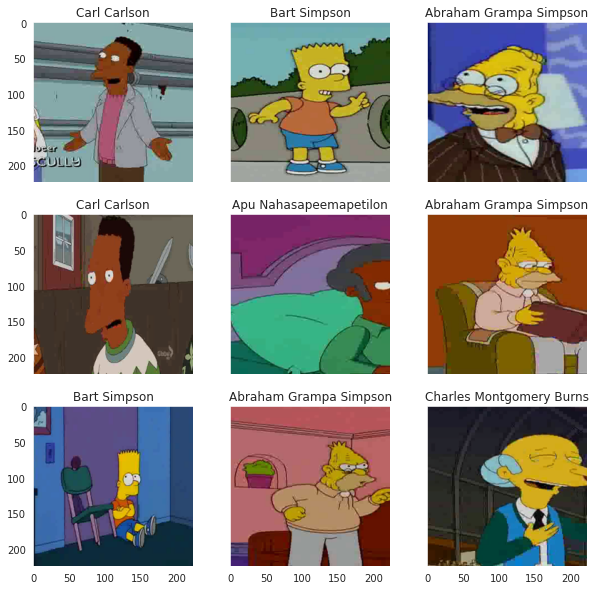

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(10, 10), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Данные загружены. Можем приступать к работе. Для начала проверим работу наших функций на простейшей SimpleCNN - если все хорошо - попробуем более сложную архитектуру, попробуем tranfer learning и готовые модели

<font size="2">Data loaded. We can get to work. To begin with, let's check the work of our functions on the simplest SimpleCNN - if everything is good - we will try a more complex architecture, try tranfer learning and ready-made models</font>






## Проверка работы baseline / Checking baseline

Запустим простую сверточную нейронную сеть без претензий на качество для проверки наших функций

<font size="2">Let's run a simple, no-quality convolutional neural network to test our functions</font>






In [ ]:
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 2.5319721003278546

Epoch 001 train_loss: 2.5320     val_loss 1.8831 train_acc 0.2922 val_acc 0.4826
loss 1.4845796745137367

Epoch 002 train_loss: 1.4846     val_loss 1.2531 train_acc 0.5951 val_acc 0.6628


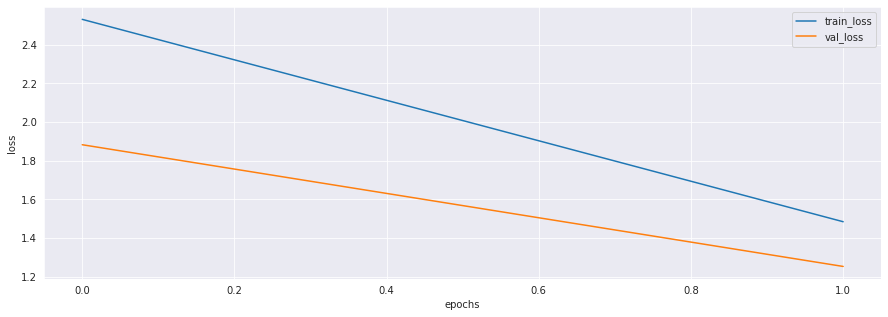

In [ ]:
opt = torch.optim.Adam(simple_cnn.parameters())
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64, optimizer=opt)

loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Все работает. Проверим, можем ли мы получать предсказания. Если все отработает без ошибок - приступим к работе с архитектурами наших сетей

<font size="2">Everything works. Let's check if we can get predictions. If everything works out without errors, let's start working with the architectures of our networks.</font>






<p align="center"><img src="https://i.ibb.co/3yXY28k/homer-simpson.jpg" ></p>

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]

probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)
label_encoder = pickle.load(open("/content/label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [label_encoder.classes_[val_dataset[id][1]] for id in idxs]
preds_class = [label_encoder.classes_[y_hat] for y_hat in y_pred]
label_encoder.transform(preds_class)
f1_score(actual_labels, preds_class, average='macro')

0.286031746031746

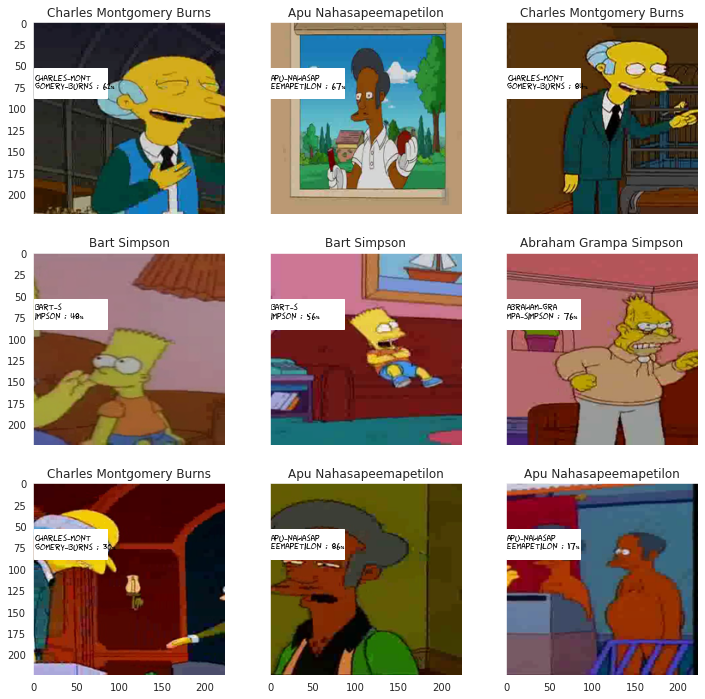

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Проверим работу нашей сети на тестовой выборке

<font size="2">Let's check the operation of our network on a test sample.</font>






In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
submission = pd.read_csv("/content/sample_submission.csv")
submission = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submission.head()

Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon

In [ ]:
submission.to_csv('cnn_baseline.csv', index=False)

In [ ]:
torch.cuda.empty_cache()

Код успешно работает - можем приступать к тестированию иных моделей

<font size="2">The code works successfully - we can start testing other models</font>






## Кастомная сверточная нейронная сеть / Custom CNN

<a id='custom'></a>

Попробуем усложнить архитектуру нейронной сети. Добавим слои, добавим нормализацию и дропаут на первый полносвязный слой после `Flatten()`. Также будем использовать шедулер - код обучения видоизменили - добавили вариант для использования шедулера. Также используем `Elu() активацию`

<font size="2">Let's try to complicate the power of the neural network. Add layers, add normalization and dropout to the first fully connected layer after `Flatten ()`. We will also use the scheduler - the learning code was modified - we added an option for using the scheduler and also - we will use `ELU()` - activation function</font>






In [ ]:
class SimpsonsConvNet(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5,
                               padding='same')

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5,
                        padding='same')
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5,
                        padding='valid')     
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(64 * 11 * 11, 300)
        self.drop = nn.Dropout(0.5)
        self.fc2 = nn.Linear(300, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, 50)
        self.fc5 = nn.Linear(50, n_classes)

    def forward(self, x):    
        x = self.pool(self.bn1(F.elu(self.conv1(x))))
        x = self.pool(self.bn1(F.elu(self.conv2(x))))
        x = self.pool(self.bn1(F.elu(self.conv3(x))))
        x = self.pool(F.elu(self.conv3(x)))
        x = self.flat(x)
        x = self.drop(F.elu(self.fc1(x)))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = self.fc5(x)
        return x

In [ ]:
n_classes = len(np.unique(train_val_labels))
custom_cnn = SimpsonsConvNet(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')
print(custom_cnn)

we will classify :42
SimpsonsConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=valid)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=7744, out_features=300, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=50, bias=True)
  (fc5): Linear(in_features=50, out_features=42, bias=True)
)


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 2.236766461878341

Epoch 001 train_loss: 2.2368     val_loss 3.2003 train_acc 0.3886 val_acc 0.1238
loss 1.537304989471049

Epoch 002 train_loss: 1.5373     val_loss 1.3093 train_acc 0.5762 val_acc 0.6406
loss 1.0093643916428519

Epoch 003 train_loss: 1.0094     val_loss 1.1079 train_acc 0.7207 val_acc 0.7029
loss 0.6577998473125017

Epoch 004 train_loss: 0.6578     val_loss 1.0575 train_acc 0.8086 val_acc 0.7287
loss 0.4421020753055676

Epoch 005 train_loss: 0.4421     val_loss 1.2095 train_acc 0.8655 val_acc 0.7205
loss 0.2982674534606705

Epoch 006 train_loss: 0.2983     val_loss 1.1428 train_acc 0.9095 val_acc 0.7507
loss 0.10440785767988327

Epoch 007 train_loss: 0.1044     val_loss 1.0212 train_acc 0.9708 val_acc 0.7910
loss 0.041646200235233286

Epoch 008 train_loss: 0.0416     val_loss 1.0722 train_acc 0.9911 val_acc 0.7950
loss 0.023483225465209076

Epoch 009 train_loss: 0.0235     val_loss 1.1269 train_acc 0.9968 val_acc 0.7942
loss 0.014414733474030906

Epoch 010 train_

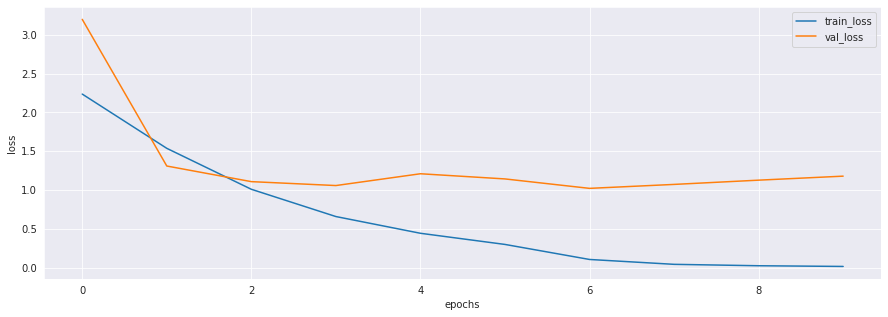

In [ ]:
lr = 1e-3
opt = torch.optim.Adam(custom_cnn.parameters(), lr=lr)
exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)

history = train(train_dataset, val_dataset, 
                model=custom_cnn, epochs=10, 
                batch_size=64, optimizer=opt,
                scheduler=exp_lr_scheduler
                )

loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Посмотрим как наша нейронная сеть работает на тестовой выборке. Стоит отметить - сеть сильно переобучается

<font size="2">Let's see how our neural network works on a test sample. It is worth noting - the network is heavily retraining </font>






In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(custom_cnn, test_loader)
label_encoder = pickle.load(open("/content/label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
submission = pd.read_csv("/content/sample_submission.csv")
submission = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submission.head()

Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon

In [ ]:
submission.to_csv('customs_cnn.csv', index=False)

In [ ]:
torch.cuda.empty_cache()

### Kaggle score

In [ ]:
kaggle = 0.96068
print(f'Kaggle score for Customs_cnn is {kaggle} f1_score')

Kaggle score for Customs_cnn is 0.96068 f1_score


Результат - неудовлетворительный. Попробуем на данном сете готовые архитектуры - затем будем применть различные техники transfer learning - сначала будем пробовать только Feature extraction, затем попробуем FineTuning, если результаты будут плохими

<font size="2">The result is unsatisfactory. Let's try ready-made architectures on this network - then we will apply various transfer learning techniques first we will try only Feature extraction, then we will try FineTuning if the results are bad </font>






## Feature Extractor для ResNet50 из зоопарка моделей / Feature Extractor of ResNet50 from Zoo of models 

Попробуем для начала взять `предобученную модель` из зоопарка - менять ничего не будем. Делаем как есть. Используем `Feature Extractor` метод. 


<font size="2">Let's try to start with a `pre-trained model` from the zoo - we won't change anything. We do it as it is. We use the `Feature Extractor` method.
 </font>






In [ ]:
ResNet50_model = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
%%capture
# для проверки input последнего слоя/to check the inputs of the last layer
ResNet50_model

In [ ]:
for param in ResNet50_model.parameters():
    param.requires_grad = False

На линейный слой подается 2048 признаков. Это будет наш вход. Заменим этот выход на требуемый в нашей задаче - 42 класса. Количество эпох менять не будем и шедулер, а learning rate немного увеличим. Использовать будем AdamW

<font size="2">
2048 features are fed to the linear layer. This will be our entrance. Let's replace this output with the required one in our problem - 42 classes. The number of epochs will not be changed, but the learning rate will be slightly increased. We will use AdamW </font>






In [ ]:
num_features = 2048
n_classes = len(np.unique(train_val_labels))
ResNet50_model.fc = nn.Linear(num_features, n_classes)

ResNet50_model.cuda()
optimizer = optim.AdamW(ResNet50_model.parameters(), lr=1e-2, weight_decay=0.005)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 2.889457208186595

Epoch 001 train_loss: 2.8895     val_loss 1.4180 train_acc 0.5478 val_acc 0.6901
loss 1.2750285100964227

Epoch 002 train_loss: 1.2750     val_loss 1.2638 train_acc 0.7106 val_acc 0.7214
loss 1.1573376653756189

Epoch 003 train_loss: 1.1573     val_loss 1.3750 train_acc 0.7359 val_acc 0.7373
loss 1.101166331055772

Epoch 004 train_loss: 1.1012     val_loss 1.7553 train_acc 0.7515 val_acc 0.6813
loss 0.9884247564040853

Epoch 005 train_loss: 0.9884     val_loss 1.4656 train_acc 0.7715 val_acc 0.7279
loss 0.9151759332012572

Epoch 006 train_loss: 0.9152     val_loss 1.5526 train_acc 0.7841 val_acc 0.7325
loss 0.3875692604916803

Epoch 007 train_loss: 0.3876     val_loss 0.8860 train_acc 0.8914 val_acc 0.8026
loss 0.32635546171104796

Epoch 008 train_loss: 0.3264     val_loss 0.8829 train_acc 0.9060 val_acc 0.7994
loss 0.29982496718782037

Epoch 009 train_loss: 0.2998     val_loss 0.8610 train_acc 0.9143 val_acc 0.8065
loss 0.28490246762606103

Epoch 010 train_loss

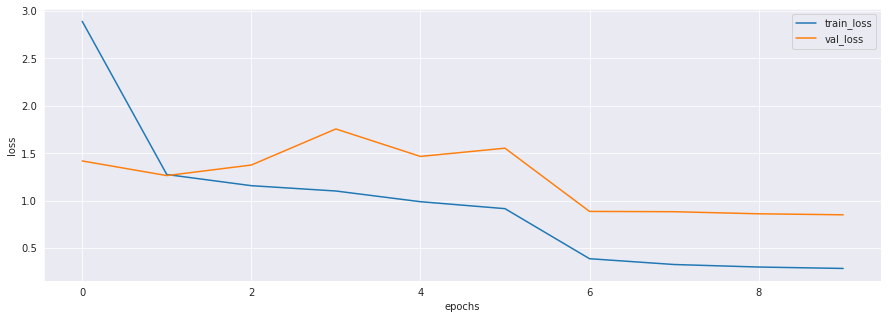

In [ ]:
history = train(train_dataset, val_dataset, 
                model=ResNet50_model, epochs=10, 
                batch_size=64, optimizer=optimizer,
                scheduler=exp_lr_scheduler
                )

loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Посмотрим как наша нейронная сеть работает на тестовой выборке. Неудивительно, что сеть переобучается - это свойственно глубоким сетям. Сеть не так сильно переобучается как наша [кастомная](#custom)

<font size="2">Let's see how our neural network works on a test sample. Unsurprisingly, the network is overfitting - this is typical of deep networks. The network is not retrained as much as our custom one  </font>






In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(ResNet50_model, test_loader)
label_encoder = pickle.load(open("/content/label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
submission = pd.read_csv("/content/sample_submission.csv")
submission = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submission.head()

Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon

In [ ]:
submission.to_csv('ResNet50_fa.csv', index=False)

In [ ]:
torch.cuda.empty_cache()

### Kaggle score

In [ ]:
kaggle = 0.82571
print(f'Kaggle score for ResNet50_finetuned is {kaggle} f1_score')

Kaggle score for ResNet50_finetuned is 0.82571 f1_score


Результат - крайне неудовлетворительный. Но модель хорошо обобщается - можно попробовать больше эпох - или увеличить lr или использовать FineTuning, но попробуем VGG16 

<font size="2">The result is extremely unsatisfactory. But the model generalizes well - you can try more epochs - or increase lr or use FineTuning, but let's try VGG16 </font>






<img src="https://i.ibb.co/LJShvYH/SAY-DOH.jpg" alt="SAY-DOH" border="0"></a>

## Feature Extractor для VGG16 из зоопарка моделей / Feature Extractor with VGG16 from zoo of models

Модель - `VGG16`, слои заморожены, пересоздали голову

<font size="2">Model - VGG16, layers frozen, re-created head. Backbone is VGG16 </font>






In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
vgg16_aug = models.vgg16(pretrained=True)

In [ ]:
%%capture
# для проверки input последнего слоя/to check the inputs of the last layer
vgg16_aug

In [ ]:
for param in vgg16_aug.parameters():
    param.requires_grad = False

Аналогично, на линейный слой подается 25088 признаков. Это будет наш вход. Заменим этот выход на требуемый в нашей задаче - 42 класса. Поменяем количество эпох на `10`, lr на `0.0001` и оптимизатор возьмет `AdamW`

<font size="2">
Likewise, 25088 features are fed to the line layer. This will be our entrance. Let's replace this output with the required one in our problem - 42 classes. Let's change the number of epochs to 25, lr to 0.0001 and the optimizer will take AdamW </font>






In [ ]:
num_features = 25088
n_classes = len(np.unique(train_val_labels))
vgg16_aug.classifier = nn.Linear(num_features, n_classes)

vgg16_aug.cuda()
optimizer = optim.AdamW(vgg16_aug.parameters(), lr=1e-4, weight_decay=0.005)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

___
 <font size="1"> Обучение проводилось на функции обучения из бейзлайна. Далее она была модифицирована. Если необходимо повторить данные результаты - запускать надо без ранней остановки </font>

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.7591197018152862

Epoch 001 train_loss: 1.7591     val_loss 1.1147 train_acc 0.5715 val_acc 0.7390
loss 0.5803502263312993

Epoch 002 train_loss: 0.5804     val_loss 0.8802 train_acc 0.8841 val_acc 0.7898
loss 0.30051415684276483

Epoch 003 train_loss: 0.3005     val_loss 0.8255 train_acc 0.9614 val_acc 0.8013
loss 0.17627599073679662

Epoch 004 train_loss: 0.1763     val_loss 0.7919 train_acc 0.9875 val_acc 0.8044
loss 0.11227823201695311

Epoch 005 train_loss: 0.1123     val_loss 0.7729 train_acc 0.9959 val_acc 0.8112
loss 0.07605161979040855

Epoch 006 train_loss: 0.0761     val_loss 0.7559 train_acc 0.9989 val_acc 0.8139
loss 0.054535378441257276

Epoch 007 train_loss: 0.0545     val_loss 0.7524 train_acc 0.9997 val_acc 0.8147
loss 0.052721576185587204

Epoch 008 train_loss: 0.0527     val_loss 0.7521 train_acc 0.9997 val_acc 0.8149
loss 0.05104327388546772

Epoch 009 train_loss: 0.0510     val_loss 0.7496 train_acc 0.9996 val_acc 0.8170
loss 0.04932168130662321

Epoch 010 t

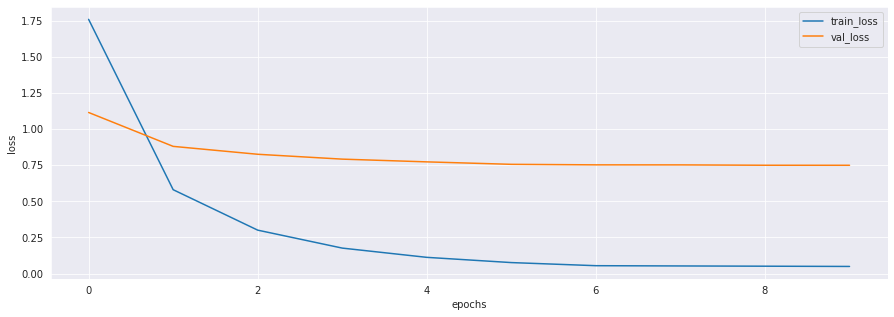

In [ ]:
history = train(train_dataset, val_dataset, 
                model=vgg16_aug, epochs=10, 
                batch_size=64, optimizer=optimizer,
                scheduler=exp_lr_scheduler
                )

loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Посмотрим как наша нейронная сеть работает на тестовой выборке. Естественно - сеть сильно переобучается

<font size="2">Let's see how our neural network works on a test sample. Naturally - the network is heavily Overfitted </font>






In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(vgg16_aug, test_loader)
label_encoder = pickle.load(open("/content/label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
submission = pd.read_csv("/content/sample_submission.csv")
submission = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submission.head()

Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon

In [ ]:
submission.to_csv('vgg16_aug.csv', index=False)

In [ ]:
torch.cuda.empty_cache()

### Kaggle score

In [ ]:
kaggle = 0.95217
print(f'Kaggle score for vgg16_aug is {kaggle} f1_score')

Kaggle score for vgg16_aug is 0.95217 f1_score


Результат - неудовлетворительный. Попробуем ансамбль

<font size="2">The result is unsatisfactory. Let's try ensemble </font>






## Ансамбль из кастомной нейронной сети / Ensemble of Custom CNN

Попробуем использовать ансамбль из нашей [кастомной модели](#custom)

<font size="2">Let's try to use an ensemble from our custom model</font>






In [ ]:
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 5e-4
EPOCHS = 10
BATCH_SIZE = 64

Создадим отдельно снова наши сеты

<font size="2">Let's create our sets separately from notebook again </font>






In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
n_classes = len(np.unique(train_val_labels))
base_estimator = SimpsonsConvNet(n_classes)
print("we will classify :{}".format(n_classes))
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')
print(base_estimator)

we will classify :42
SimpsonsConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=valid)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=7744, out_features=300, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=50, bias=True)
  (fc5): Linear(in_features=50, out_features=42, bias=True)
)


Теперь создадим ансамбль моделей

<font size="2">Now let's create an ensemble of models </font>






In [ ]:
#создаем ансамбль / ensemble creation
ensemble = VotingClassifier(
    estimator=base_estimator,               
    n_estimators=5,  
    cuda=True                   
)

# устанавливаем оптимизатор / set optimizer
ensemble.set_optimizer(
    "Adam",       
    lr=LEARNING_RATE,          
    weight_decay=WEIGHT_DECAY,    

)

#устанавливаем шедулер / set scheduler
ensemble.set_scheduler(
    "CosineAnnealingLR",                    
    T_max=EPOCHS,                           
)

In [ ]:
# обучение / train ensemble
ensemble.fit(
    train_loader,
    epochs=EPOCHS, 
    log_interval=200,
    test_loader=val_loader
)

Для удобства просмотра, ниже представлены только результаты последней эпохи  
<font size="2">Only the results of the last epoch are presented below. </font>
```
Estimator: 000 | Epoch: 009 | Batch: 000 | Loss: 0.13897 | Correct: 60/64
Estimator: 000 | Epoch: 009 | Batch: 200 | Loss: 0.11262 | Correct: 62/64
Estimator: 001 | Epoch: 009 | Batch: 000 | Loss: 0.27828 | Correct: 59/64
Estimator: 001 | Epoch: 009 | Batch: 200 | Loss: 0.10790 | Correct: 62/64
Estimator: 002 | Epoch: 009 | Batch: 000 | Loss: 0.08313 | Correct: 63/64
Estimator: 002 | Epoch: 009 | Batch: 200 | Loss: 0.21952 | Correct: 61/64
Estimator: 003 | Epoch: 009 | Batch: 000 | Loss: 0.11240 | Correct: 62/64
Estimator: 003 | Epoch: 009 | Batch: 200 | Loss: 0.13328 | Correct: 62/64
Estimator: 004 | Epoch: 009 | Batch: 000 | Loss: 0.12916 | Correct: 61/64
Estimator: 004 | Epoch: 009 | Batch: 200 | Loss: 0.21589 | Correct: 60/64
```

Ниже код загрузки модели с диска  в формате `pth`. Необходимо убрать `%%capture` команду

<font size="2">Below is the code for loading the model from disk in `pth`. Del `%%capture` magic command </font>











In [ ]:
%%capture
!gdown --id 14Fc-hk3R0hYX8xmL3rwM0n487eEq7-0s

Все работает. Проверим, можем ли мы получать предсказания.  
<font size="2">Everything works. Let's check if we can get predictions. If everything works out without errorsks</font>






In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]

probs_im = predict_one_sample(ensemble, ex_img.unsqueeze(0))
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(ensemble, imgs)
label_encoder = pickle.load(open("/content/label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [label_encoder.classes_[val_dataset[id][1]] for id in idxs]
preds_class = [label_encoder.classes_[y_hat] for y_hat in y_pred]
label_encoder.transform(preds_class)
f1_score(actual_labels, preds_class, average='weighted')

0.8045054945054945

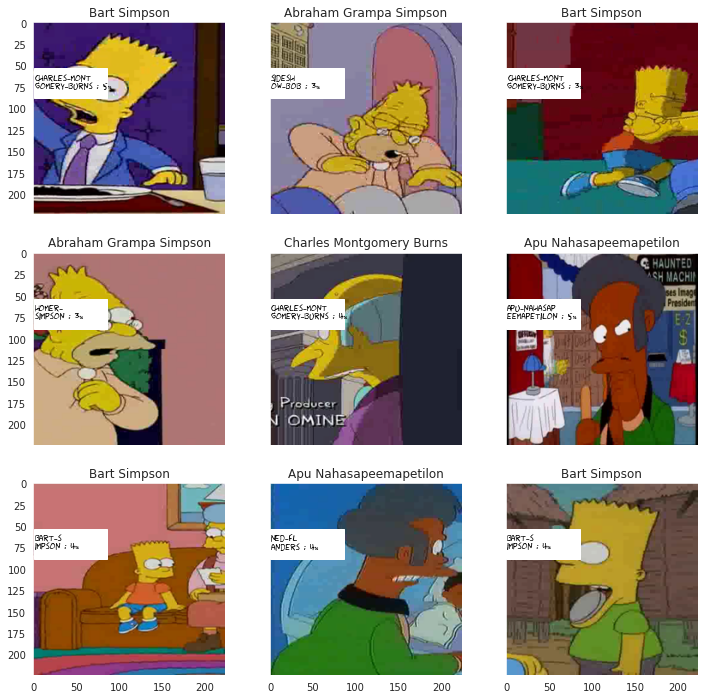

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(ensemble, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Посмотрим как наша ансамбль работает на тестовой выборке.

<font size="2">Let's see how our ensemble of neural networks works on a test sample.  </font>






In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

In [ ]:
probs = predict(ensemble, test_loader)

In [ ]:
label_encoder = pickle.load(open("/content/label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
submission = pd.read_csv("/content/sample_submission.csv")
submission = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submission.head()

Id                Expected
0    img0.jpg            ned_flanders
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon

In [ ]:
submission.to_csv('Ensemble.csv', index=False)

In [ ]:
torch.cuda.empty_cache()

### Kaggle score

In [ ]:
kaggle = 0.47138
print(f'Kaggle score for Ensemble is {kaggle} f1_score')

Kaggle score for Ensemble is 0.47138 f1_score


Возможно есть сбой в проставлении лейблов. Будем двигаться дальше - слишком долго учится

<img src="https://i.ibb.co/jMMXtVS/256-2562494-pink-simpsons-donuts-freetoedit-homer-simpson-hd-png.png" alt="256-2562494-pink-simpsons-donuts-freetoedit-homer-simpson-hd-png" border="0">

## Feature Extractor для EfficientNet и Аугментация / Feature Extractor of EfficientNet and Augmentation

Попробуем для начала взять `предобученную модель` из зоопарка - менять ничего не будем. Делаем как есть. Используем `Feature Extractor` метод, добавим аугментации (используем новый класс [SimpsonsDatasetAug](#simp))


<font size="2">Let's try to start with a `pre-trained model` from the zoo - we won't change anything. We do it as it is. We use the `Feature Extractor` method. It is pointless to use `FineTuning` in this situation and [SimpsonsDatasetAug](#simp)</font>






In [ ]:
val_dataset = SimpsonsDatasetAug(val_files, mode='val')
train_dataset = SimpsonsDatasetAug(train_files, mode='train')

In [ ]:
Eff_mod = EfficientNet.from_pretrained('efficientnet-b2')

Loaded pretrained weights for efficientnet-b2


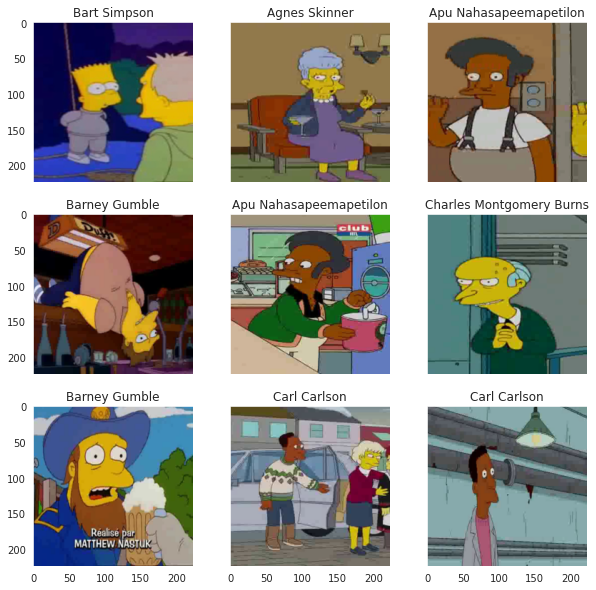

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(10, 10), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [ ]:
%%capture
# для проверки input последнего слоя/to check the inputs of the last layer
Eff_mod

In [ ]:
for param in Eff_mod.parameters():
    param.requires_grad = False

Заменим этот выход на требуемый в нашей задаче - `42 класса`. Использовать будем AdamW и количесто эпох установим на 50 с ранней остановкой, шедулер на 10 шагов, batch_size на 256

<font size="2">Let's replace this output with the one required in our task - `42 classes`. We will use `AdamW` and set the number of epochs to `50` with shceduler for 10 steps and batch of 256 samples </font>






In [ ]:
num_features = Eff_mod._fc.in_features
Eff_mod._fc = nn.Linear(num_features, n_classes)

Eff_mod.cuda()
optimizer = optim.AdamW(Eff_mod.parameters(), lr=1e-3, weight_decay=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
history = train(train_dataset, val_dataset, 
                model=Eff_mod, epochs=50, 
                batch_size=256, optimizer=optimizer,
                scheduler=exp_lr_scheduler,
                patience=5
                )

loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Для удобства просмотра, ниже представлены только резуьтаты последнех эпох   
<font size="2">Only the results of the last epochs are presented below. </font>
```
Epoch 047 train_loss: 0.7733     val_loss 0.8929 train_acc 0.8064 val_acc 0.7721
loss 0.7719837215092693

Epoch 048 train_loss: 0.7720     val_loss 0.8929 train_acc 0.8071 val_acc 0.7721
loss 0.7687502685789318

Epoch 049 train_loss: 0.7688     val_loss 0.8929 train_acc 0.8085 val_acc 0.7721
loss 0.7664765505374894

Epoch 050 train_loss: 0.7665     val_loss 0.8929 train_acc 0.8074 val_acc 0.7721
```

<img src="https://i.ibb.co/PrpTyvm/image.png" alt="image" border="0">

Сеть достаточно плохо обучается в таком состоянии - попали в плато. Будем пробовать иные методы. Но проверим эту сеть на тестовой выборке, конечно же

<font size="2"> The network learns rather poorly in this state. We will try other methods. But let's check this network on a test sample, of course </font>






In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]

probs_im = predict_one_sample(Eff_mod, ex_img.unsqueeze(0))
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(Eff_mod, imgs)
label_encoder = pickle.load(open("/content/label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [label_encoder.classes_[val_dataset[id][1]] for id in idxs]
preds_class = [label_encoder.classes_[y_hat] for y_hat in y_pred]
label_encoder.transform(preds_class)
f1_score(actual_labels, preds_class, average='weighted')

0.9045454545454545

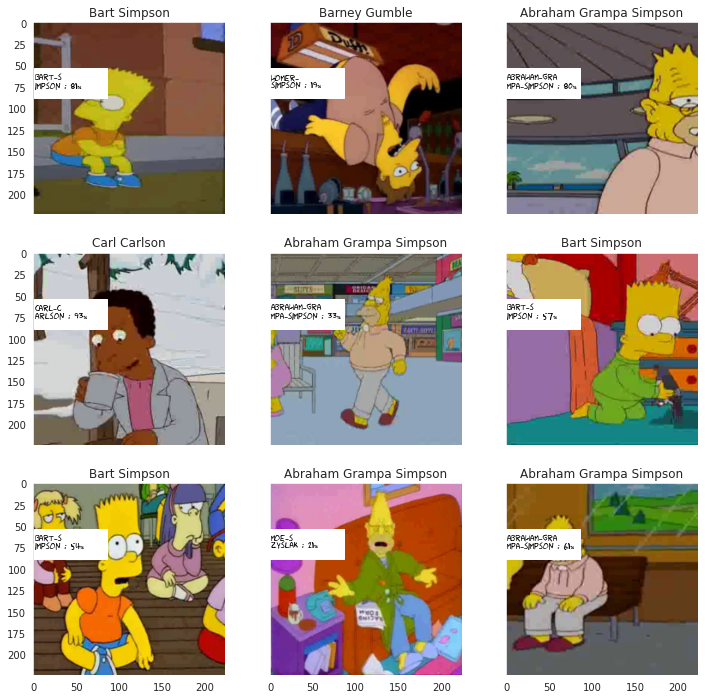

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(Eff_mod, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Посмотрим как наша сеть работает на тестовой выборке.

<font size="2">Let's see how our neural network works on a test sample.  </font>






In [ ]:
test_dataset = SimpsonsDatasetAug(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=256)

In [ ]:
probs = predict(Eff_mod, test_loader)

In [ ]:
label_encoder = pickle.load(open("/content/label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
submission = pd.read_csv("/content/sample_submission.csv")
submission = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submission.head()

Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon

In [ ]:
submission.to_csv('efficientnet.csv', index=False)

In [ ]:
files.download('efficientnet.csv')

In [ ]:
torch.cuda.empty_cache()

### Kaggle score

In [ ]:
kaggle = 0.80808
print(f'Kaggle score for efficientnet is {kaggle} f1_score')

Kaggle score for efficientnet is 0.80808 f1_score


<img src="https://i.ibb.co/DkYRYdz/THE-SIMPSONS-Lisa-must-defend-her-brother-in-youth-court-when-he-is-falsely-accused-of-pulling-an-Ea.jpg" alt="THE-SIMPSONS-Lisa-must-defend-her-brother-in-youth-court-when-he-is-falsely-accused-of-pulling-an-Ea" border="0">

Очень плохо. Но Мы можем попробовать сделать что то с размером батча или лёрнинг рейтом, но сначала попробуем балансировку классов - вернее оверсамплинг

<font size="2">Very bad. We need to do something with batch_size or lr. Let us try oversampling)  </font>






## Работа с [балансом классов](https://discuss.pytorch.org/t/how-to-implement-oversampling-in-cifar-10/16964/5) на SimpsonsConvNet/  [Class balancing](https://discuss.pytorch.org/t/how-to-implement-oversampling-in-cifar-10/16964/5) with SimpsonsConvNet

<a id='previous'></a>

Пример на [Kaggle - Volcanoes](https://www.kaggle.com/renatobmlr/pytorch-imbalanced-classes)

<font size="2">Example [Kaggle - Volcanoes](https://www.kaggle.com/renatobmlr/pytorch-imbalanced-classes) </font>

Попробуем софрмировать сбалансированные выборки - по крайней мере используем оверсамплинг для редких классов. Это может помочь нашей сети в предсказания

<font size="2">Let's try to refine the balanced samples. This can help our network to predict  </font>






In [ ]:
TRAIN_DIR = Path('/content/train')
TEST_DIR = Path('/content/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
len(train_val_files)

20933

Воспользуемся функцией, что мы написали. Дальше как обычно - сформируем сеты, обучим сеть, протестируем на одном образце и на тесте. Сеть наверняка будет склонна к переобучению. Выстаим ожидание на 5 эпох

<font size="2"> Let's use the function that we have written. Then, as usual, we will form the sets, train the network, test it on one sample and on the test. The network is likely to be prone to overfitting. Patience set on 5 epochs </font>






In [ ]:
y_train_val = [path.parent.name for path in train_val_files]

In [ ]:
Counter(y_train_val)

Counter({'abraham_grampa_simpson': 913,
         'agnes_skinner': 42,
         'apu_nahasapeemapetilon': 623,
         'barney_gumble': 106,
         'bart_simpson': 1342,
         'carl_carlson': 98,
         'charles_montgomery_burns': 1193,
         'chief_wiggum': 986,
         'cletus_spuckler': 47,
         'comic_book_guy': 469,
         'disco_stu': 8,
         'edna_krabappel': 457,
         'fat_tony': 27,
         'gil': 27,
         'groundskeeper_willie': 121,
         'homer_simpson': 2246,
         'kent_brockman': 498,
         'krusty_the_clown': 1206,
         'lenny_leonard': 310,
         'lionel_hutz': 3,
         'lisa_simpson': 1354,
         'maggie_simpson': 128,
         'marge_simpson': 1291,
         'martin_prince': 71,
         'mayor_quimby': 246,
         'milhouse_van_houten': 1079,
         'miss_hoover': 17,
         'moe_szyslak': 1452,
         'ned_flanders': 1454,
         'nelson_muntz': 358,
         'otto_mann': 32,
         'patty_bouvier': 72

Мы видим, что некоторых классов представленно слишком мало

<font size="2"> We see that some classes are too few </font>






In [ ]:
balanced, y_balanced, val_files, y_val = balancing_data(train_val_files, 75)

Теперь представителей маленьких классов должно стать 75 (этот параметр можно приравнять к гиперпараметрам сети и подбирать)

<font size="2"> Now there should be 75 representatives of small classes </font>






In [ ]:
Counter(y_balanced)

Counter({'abraham_grampa_simpson': 685,
         'agnes_skinner': 75,
         'apu_nahasapeemapetilon': 467,
         'barney_gumble': 80,
         'bart_simpson': 1006,
         'carl_carlson': 75,
         'charles_montgomery_burns': 895,
         'chief_wiggum': 739,
         'cletus_spuckler': 75,
         'comic_book_guy': 352,
         'disco_stu': 75,
         'edna_krabappel': 343,
         'fat_tony': 75,
         'gil': 75,
         'groundskeeper_willie': 91,
         'homer_simpson': 1684,
         'kent_brockman': 373,
         'krusty_the_clown': 904,
         'lenny_leonard': 233,
         'lionel_hutz': 75,
         'lisa_simpson': 1015,
         'maggie_simpson': 96,
         'marge_simpson': 968,
         'martin_prince': 75,
         'mayor_quimby': 185,
         'milhouse_van_houten': 809,
         'miss_hoover': 75,
         'moe_szyslak': 1089,
         'ned_flanders': 1090,
         'nelson_muntz': 269,
         'otto_mann': 75,
         'patty_bouvier': 75,
   

In [ ]:
len(val_files)

5234

In [ ]:
len(balanced)

16414

In [ ]:
val_dataset = SimpsonsDatasetAug(val_files, mode='val')
train_dataset = SimpsonsDatasetAug(balanced, mode='train')

In [ ]:
n_classes = len(np.unique(y_train_val))
custom_cnn = SimpsonsConvNet(n_classes).to(DEVICE)

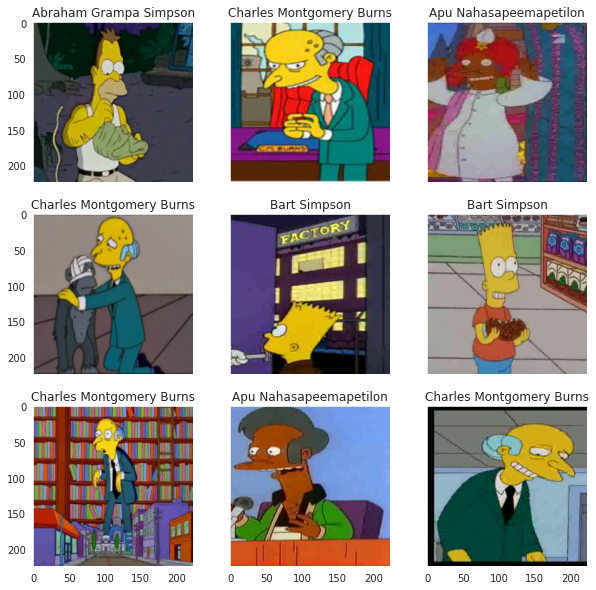

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(10, 10), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Установим сначала большой `learning_rate`, затем будем понижать каждые 10 эпох. Установим раннюю остановку. `Batch_size` установим на 64 - у нас стало больше образцов

<font size="2"> First, we will set a large `learning_rate`, then we will lower it every 10 epochs. Set up an early stop. `Batch_size` set on 64</font>






In [ ]:
lr = 1e-3
opt = torch.optim.Adam(custom_cnn.parameters(), lr=lr)
exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

loss 2.5222283266661765

Epoch 001 train_loss: 2.5222     val_loss 3.2157 train_acc 0.3181 val_acc 0.1509
loss 1.7429976834004002

Epoch 002 train_loss: 1.7430     val_loss 1.4538 train_acc 0.5226 val_acc 0.6007
loss 1.3150684708463618

Epoch 003 train_loss: 1.3151     val_loss 1.1955 train_acc 0.6287 val_acc 0.6674
loss 1.0675425311745455

Epoch 004 train_loss: 1.0675     val_loss 1.0869 train_acc 0.6962 val_acc 0.7079
loss 0.8925471700500074

Epoch 005 train_loss: 0.8925     val_loss 1.0506 train_acc 0.7450 val_acc 0.7211
loss 0.7431122082892355

Epoch 006 train_loss: 0.7431     val_loss 0.9513 train_acc 0.7841 val_acc 0.7572
loss 0.6356781322395118

Epoch 007 train_loss: 0.6357     val_loss 0.9304 train_acc 0.8176 val_acc 0.7661
loss 0.5552816771445618

Epoch 008 train_loss: 0.5553     val_loss 0.8429 train_acc 0.8388 val_acc 0.7812
loss 0.48055684840300056

Epoch 009 train_loss: 0.4806     val_loss 0.8390 train_acc 0.8616 val_acc 0.7938
loss 0.462311313952513

Epoch 010 train_loss:

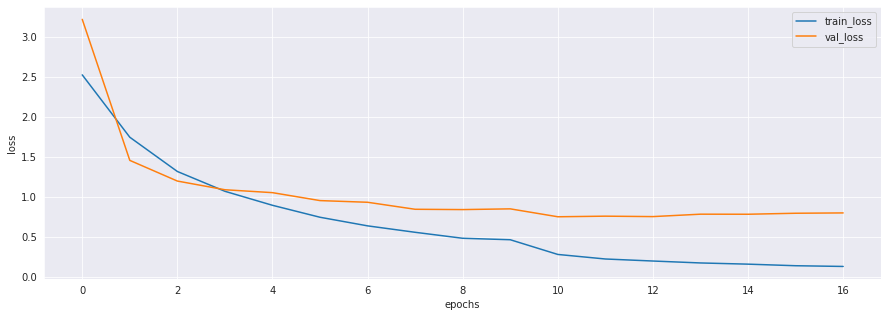

In [ ]:
history = train(train_dataset,
                val_dataset,
                model=custom_cnn,
                epochs=30, 
                batch_size=64,
                optimizer=opt,
                scheduler=exp_lr_scheduler,
                patience=5
                )

loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Ниже - результаты кастомной сети без самплинга:

```
Epoch 010 train_loss: 0.0144     val_loss 1.1787 train_acc 0.9983 val_acc 0.7940
```

Отлично. Сработала рання остановка. 

<font size="2"> Fine. An earlystopping was triggered. </font>






In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]

probs_im = predict_one_sample(custom_cnn, ex_img.unsqueeze(0))
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(custom_cnn, imgs)
label_encoder = pickle.load(open("/content/label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [label_encoder.classes_[val_dataset[id][1]] for id in idxs]
preds_class = [label_encoder.classes_[y_hat] for y_hat in y_pred]
label_encoder.transform(preds_class)
f1_score(actual_labels, preds_class, average='weighted')

0.894155844155844

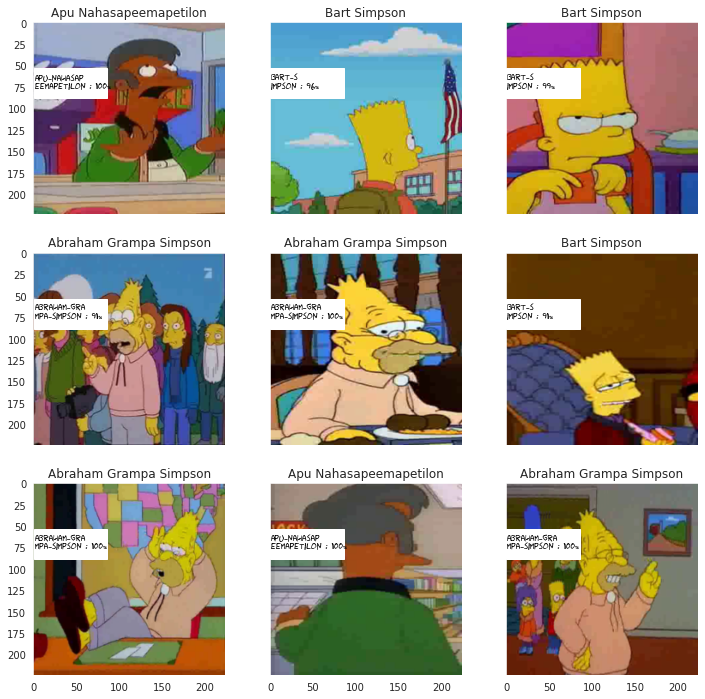

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(custom_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Посмотрим как наша сеть работает на тестовой выборке.

<font size="2">Let's see how our neural network works on a test sample.  </font>






In [ ]:
test_dataset = SimpsonsDatasetAug(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

In [ ]:
probs = predict(custom_cnn, test_loader)

In [ ]:
label_encoder = pickle.load(open("/content/label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
submission = pd.read_csv("/content/sample_submission.csv")
submission = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submission.head()

Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon

In [ ]:
submission.to_csv('balanced_custom.csv', index=False)

In [ ]:
files.download('balanced_custom.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
torch.cuda.empty_cache()

### Kaggle score

In [ ]:
kaggle = 0.92255
print(f'Kaggle score for Custom_balanced is {kaggle} f1_score')

Kaggle score for Custom_balanced is 0.92255 f1_score


## Работа с [балансом классов](https://discuss.pytorch.org/t/how-to-implement-oversampling-in-cifar-10/16964/5) на ArtyNet/  [Class balancing](https://discuss.pytorch.org/t/how-to-implement-oversampling-in-cifar-10/16964/5) with ArtyNet

<a id='artybal'></a>

Пример на [Kaggle - Volcanoes](https://www.kaggle.com/renatobmlr/pytorch-imbalanced-classes) / <font size="2">Example [Kaggle - Volcanoes](https://www.kaggle.com/renatobmlr/pytorch-imbalanced-classes) </font>

Попробуем софрмировать сбалансированные выборки - по крайней мере используем оверсамплинг для редких классов. Это может помочь нашей сети в предсказания. Сделаем аналогично [предыдущему пункту](#previous), но перепишим кастомную сеть

<font size="2">Let's try to refine the balanced samples. This can help our network to predict. Let's do it similarly to the previous point, but rewrite the custom network  </font>






In [ ]:
TRAIN_DIR = Path('/content/train')
TEST_DIR = Path('/content/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
len(train_val_files)

20933

Воспользуемся функцией, что мы написали. Дальше как обычно - сформируем сеты, обучим сеть, протестируем на одном образце и на тесте. Сеть наверняка будет склонна к переобучению. Выстаим ожидание на 5 эпох

<font size="2"> Let's use the function that we have written. Then, as usual, we will form the sets, train the network, test it on one sample and on the test. The network is likely to be prone to overfitting. Patience set on 5 epochs </font>






In [ ]:
y_train_val = [path.parent.name for path in train_val_files]

In [ ]:
Counter(y_train_val)

Counter({'abraham_grampa_simpson': 913,
         'agnes_skinner': 42,
         'apu_nahasapeemapetilon': 623,
         'barney_gumble': 106,
         'bart_simpson': 1342,
         'carl_carlson': 98,
         'charles_montgomery_burns': 1193,
         'chief_wiggum': 986,
         'cletus_spuckler': 47,
         'comic_book_guy': 469,
         'disco_stu': 8,
         'edna_krabappel': 457,
         'fat_tony': 27,
         'gil': 27,
         'groundskeeper_willie': 121,
         'homer_simpson': 2246,
         'kent_brockman': 498,
         'krusty_the_clown': 1206,
         'lenny_leonard': 310,
         'lionel_hutz': 3,
         'lisa_simpson': 1354,
         'maggie_simpson': 128,
         'marge_simpson': 1291,
         'martin_prince': 71,
         'mayor_quimby': 246,
         'milhouse_van_houten': 1079,
         'miss_hoover': 17,
         'moe_szyslak': 1452,
         'ned_flanders': 1454,
         'nelson_muntz': 358,
         'otto_mann': 32,
         'patty_bouvier': 72

Мы видим, что некоторых классов представленно слишком мало

<font size="2"> We see that some classes are too few </font>






In [ ]:
balanced, y_balanced, val_files, y_val = balancing_data(train_val_files, 75)

Теперь представителей маленьких классов должно стать 75 (этот параметр можно приравнять к гиперпараметрам сети и подбирать)

<font size="2"> Now there should be 75 representatives of small classes </font>






In [ ]:
Counter(y_balanced)

Counter({'abraham_grampa_simpson': 685,
         'agnes_skinner': 75,
         'apu_nahasapeemapetilon': 467,
         'barney_gumble': 80,
         'bart_simpson': 1006,
         'carl_carlson': 75,
         'charles_montgomery_burns': 895,
         'chief_wiggum': 739,
         'cletus_spuckler': 75,
         'comic_book_guy': 352,
         'disco_stu': 75,
         'edna_krabappel': 343,
         'fat_tony': 75,
         'gil': 75,
         'groundskeeper_willie': 91,
         'homer_simpson': 1684,
         'kent_brockman': 373,
         'krusty_the_clown': 904,
         'lenny_leonard': 233,
         'lionel_hutz': 75,
         'lisa_simpson': 1015,
         'maggie_simpson': 96,
         'marge_simpson': 968,
         'martin_prince': 75,
         'mayor_quimby': 185,
         'milhouse_van_houten': 809,
         'miss_hoover': 75,
         'moe_szyslak': 1089,
         'ned_flanders': 1090,
         'nelson_muntz': 269,
         'otto_mann': 75,
         'patty_bouvier': 75,
   

In [ ]:
len(val_files)

5234

In [ ]:
len(balanced)

16414

Применим аугментацию

<font size="2"> we will use augmentation - `SimpsonsDatasetAug` </font>

In [ ]:
val_dataset = SimpsonsDatasetAug(val_files, mode='val')
train_dataset = SimpsonsDatasetAug(balanced, mode='train')

Переработаем нашу сеть. Добавим больше `Dropout` слое, добавим нормазицию. Хотя обычно на свертки `Dropout` не добавляют - мы попробуем - такая архитектура помогла на [MNIST](https://www.kaggle.com/artemsolomko/digits-recognition-with-keras-cnn-and-dnn-on-tfv1) и вот еще [статья](https://arxiv.org/abs/1905.05928v1)

<font size="2"> Let's rework our network. Add more `Dropout` layers, add normalization. Although usually `Dropou` is not added to the convolutions - we will try. I used it on [MNIST](https://www.kaggle.com/artemsolomko/digits-recognition-with-keras-cnn-and-dnn-on-tfv1) </font>






<a id='custom2'></a>

In [ ]:
class ArtyNet(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=(5, 5), 
                                             padding='same'),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(64),
                                   nn.MaxPool2d(kernel_size=2, stride=2),
                                   nn.Dropout(0.5)
                                    )

        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=(5, 5),
                                              padding='same'),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(128),
                                  nn.Dropout(0.5)
                                  )
        self.conv3 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=(5, 5), 
                                              padding='same'),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(128),
                                  nn.Dropout(0.5)
                                  )
        self.conv4 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=(5, 5), 
                                               padding='same'),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(128),
                                  nn.MaxPool2d(kernel_size=2, stride=2),
                                  nn.Dropout(0.5)
                                  )

        self.conv5 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=(5, 5), 
                                           padding='same'),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(128),
                                  nn.Dropout(0.5)
                                  )
        self.flatten = nn.Sequential(nn.Flatten(start_dim=1, end_dim=-1))
        self.linear1 = nn.Sequential(nn.Linear(in_features=401408, out_features=300),
                                  nn.ReLU(),
                                  nn.BatchNorm1d(300)
                                  )
        self.linear2 = nn.Sequential(nn.Linear(in_features=300, out_features=200),
                                  nn.ReLU(),
                                  nn.BatchNorm1d(200)
                                  )
              
        self.linear3 = nn.Sequential(nn.Linear(in_features=200, out_features=100),
                                  nn.ReLU(),
                                  nn.BatchNorm1d(100)
                                  )
        self.out = nn.Linear(in_features=100, out_features=n_classes)
          
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        logits = self.out(x)
        return logits

In [ ]:
n_classes = len(np.unique(y_balanced))
custom_cnn = ArtyNet(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(custom_cnn)

we will classify :42
ArtyNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05,

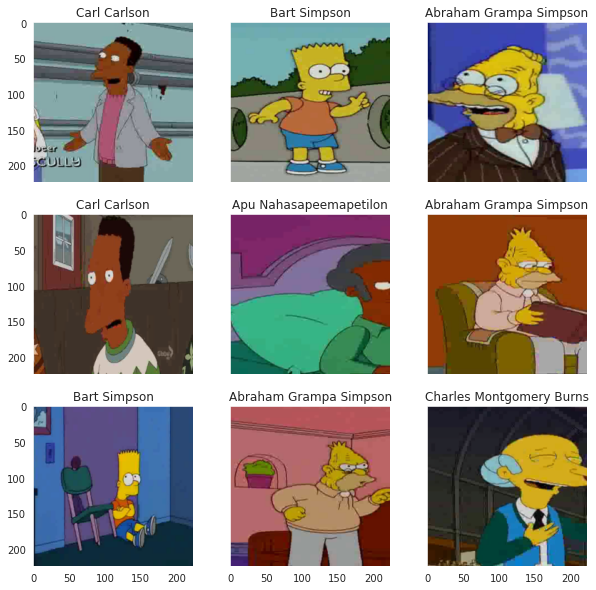

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(10, 10), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Установим сначала большой `learning_rate`, затем будем понижать каждые 10 эпох. Установим раннюю остановку. `Batch_size` установим на 64. 

<font size="2"> First, we will set a large `learning_rate`, then we will lower it every 10 epochs. Set up an early stop. `Batch_size` set on 64</font>






In [ ]:
lr = 1e-3
opt = torch.optim.Adam(custom_cnn.parameters(), lr=lr)
exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

loss 2.486117473934983

Epoch 001 train_loss: 2.4861     val_loss 1.7957 train_acc 0.3766 val_acc 0.5246
loss 1.7055412413679727

Epoch 002 train_loss: 1.7055     val_loss 1.4085 train_acc 0.5334 val_acc 0.6036
loss 1.309776086079242

Epoch 003 train_loss: 1.3098     val_loss 1.1738 train_acc 0.6336 val_acc 0.6817
loss 1.0145410937543646

Epoch 004 train_loss: 1.0145     val_loss 1.0567 train_acc 0.7118 val_acc 0.7035
loss 0.8257612540557177

Epoch 005 train_loss: 0.8258     val_loss 0.9472 train_acc 0.7594 val_acc 0.7442
loss 0.6824042275593373

Epoch 006 train_loss: 0.6824     val_loss 0.7578 train_acc 0.8038 val_acc 0.7893
loss 0.5568150686073118

Epoch 007 train_loss: 0.5568     val_loss 0.7182 train_acc 0.8379 val_acc 0.8200
loss 0.5214252932957439

Epoch 008 train_loss: 0.5214     val_loss 0.7175 train_acc 0.8478 val_acc 0.8143
loss 0.4179081094240291

Epoch 009 train_loss: 0.4179     val_loss 0.7182 train_acc 0.8757 val_acc 0.8280
loss 0.37828693216896037

Epoch 010 train_loss: 

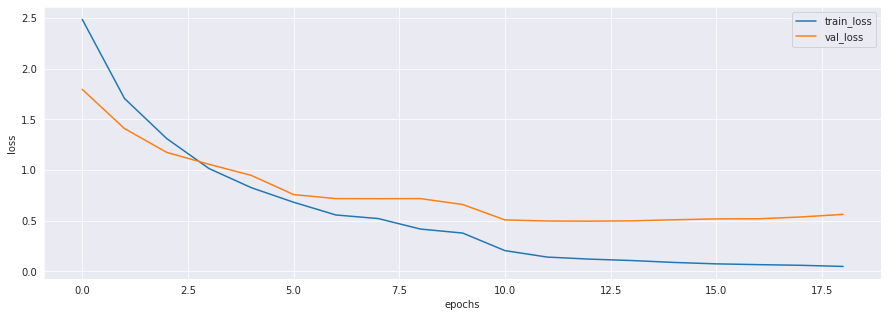

In [ ]:
history = train(train_dataset, val_dataset, 
                model=custom_cnn, epochs=30, 
                batch_size=64, optimizer=opt,
                scheduler=exp_lr_scheduler,
                patience=5
                )

loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

для сравнение результаты сети [предыдущего пункта](#previous)
```
Epoch 017 train_loss: 0.1286     val_loss 0.7973 train_acc 0.9628 val_acc 0.8376

```

Отлично. Сработала рання остановка. 

<font size="2"> Fine. An earlystopping was triggered. </font>






In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]

probs_im = predict_one_sample(custom_cnn, ex_img.unsqueeze(0))
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(custom_cnn, imgs)
label_encoder = pickle.load(open("/content/label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [label_encoder.classes_[val_dataset[id][1]] for id in idxs]
preds_class = [label_encoder.classes_[y_hat] for y_hat in y_pred]
label_encoder.transform(preds_class)
f1_score(actual_labels, preds_class, average='weighted')

0.923076923076923

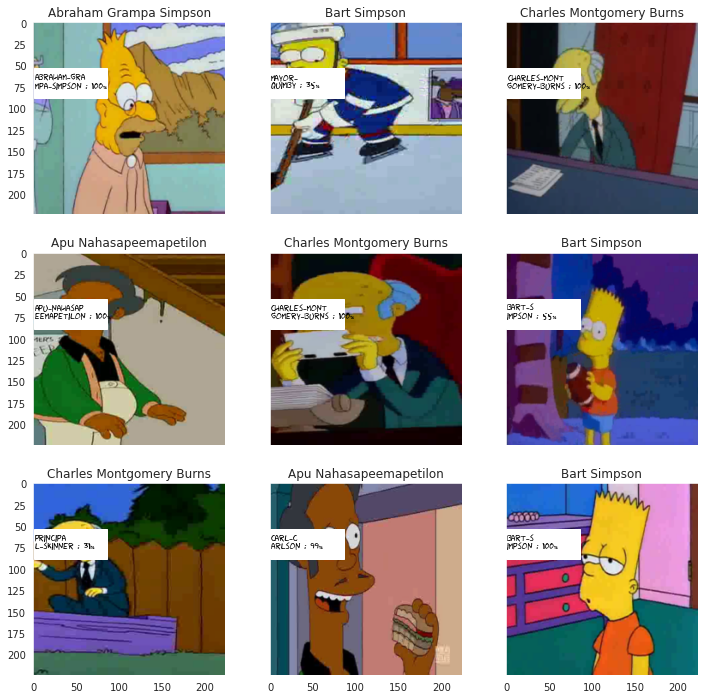

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(custom_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Посмотрим как наша сеть работает на тестовой выборке.

<font size="2">Let's see how our neural network works on a test sample.  </font>






In [ ]:
test_dataset = SimpsonsDatasetAug(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

In [ ]:
probs = predict(custom_cnn, test_loader)

In [ ]:
label_encoder = pickle.load(open("/content/label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
submission = pd.read_csv("/content/sample_submission.csv")
submission = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submission.head()

Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon

In [ ]:
submission.to_csv('artyNet.csv', index=False)

In [ ]:
files.download('artyNet.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
torch.cuda.empty_cache()

### Kaggle score

In [ ]:
kaggle = 0.96493
print(f'Kaggle score for artyNet is {kaggle} f1_score')

Kaggle score for artyNet is 0.96493 f1_score


<img src="https://i.ibb.co/NnkFJjV/tv-series-the-simpsons-61592.jpg" alt="tv-series-the-simpsons-61592" border="0"></a>

## Кастомная сверточная нейронная сеть ArtyNet на базовом датасете / Custom CNN ArtyNet on base data

Попробуем обучить сеть из [предыдущего пункта](#custom2) на базовом сете, аналогично тому, как мы делали это в пункте [Кастомная сверточная нейронная сеть](#custom)

<font size="2">Let's try to train the network from the [previous point](#custom2) on the basic data, similar to how we did it in the [Custom neural network point](#custom)</font>






In [ ]:
TRAIN_DIR = Path('/content/train')
TEST_DIR = Path('/content/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
n_classes = len(np.unique(train_val_labels))
custom_cnn = ArtyNet(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')
print(custom_cnn)

we will classify :42
ArtyNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05,

Все делаем идентично тому, что делали ранее

<font size="2">We do everything identical to what we did earlier</font>

In [ ]:
lr = 1e-3
opt = torch.optim.Adam(custom_cnn.parameters(), lr=lr)
exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

loss 2.3177587065592533

Epoch 001 train_loss: 2.3178     val_loss 1.5166 train_acc 0.4178 val_acc 0.5965
loss 1.4355405668702366

Epoch 002 train_loss: 1.4355     val_loss 1.1034 train_acc 0.6118 val_acc 0.6922
loss 0.9431989623510243

Epoch 003 train_loss: 0.9432     val_loss 0.6879 train_acc 0.7380 val_acc 0.8112
loss 0.5692161737949926

Epoch 004 train_loss: 0.5692     val_loss 0.4501 train_acc 0.8376 val_acc 0.8764
loss 0.37401503783911305

Epoch 005 train_loss: 0.3740     val_loss 0.4065 train_acc 0.8918 val_acc 0.8987
loss 0.24636856178028796

Epoch 006 train_loss: 0.2464     val_loss 0.3772 train_acc 0.9261 val_acc 0.9094
loss 0.19852876982938955

Epoch 007 train_loss: 0.1985     val_loss 0.3831 train_acc 0.9396 val_acc 0.9131
loss 0.1438626795883763

Epoch 008 train_loss: 0.1439     val_loss 0.3958 train_acc 0.9564 val_acc 0.9217
loss 0.13527305105384183

Epoch 009 train_loss: 0.1353     val_loss 0.3946 train_acc 0.9604 val_acc 0.9207
loss 0.11180961183115391

Epoch 010 train_

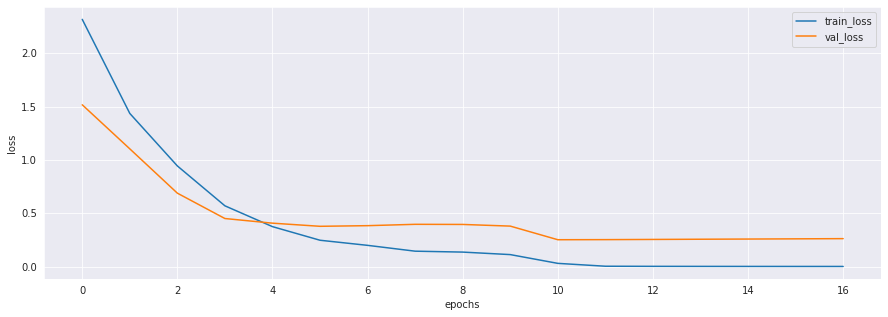

In [ ]:
history = train(train_dataset, val_dataset, 
                model=custom_cnn, epochs=25, 
                batch_size=64, optimizer=opt,
                scheduler=exp_lr_scheduler,
                patience=5
                )

loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Для сравнения, результаты [предыдущего пункта](#artybal)

```
Epoch 019 train_loss: 0.0491     val_loss 0.5626 train_acc 0.9878 val_acc 0.8942

```

Результаты данной модели  (для сохранности вывода)


```
Epoch 010 train_loss: 0.1118     val_loss 0.3790 train_acc 0.9667 val_acc 0.9243
loss 0.029614352831262597

Epoch 011 train_loss: 0.0296     val_loss 0.2513 train_acc 0.9907 val_acc 0.9557
loss 0.002730391934476249

Epoch 012 train_loss: 0.0027     val_loss 0.2522 train_acc 0.9999 val_acc 0.9561
loss 0.0017223799200703027

Epoch 013 train_loss: 0.0017     val_loss 0.2539 train_acc 0.9999 val_acc 0.9561
loss 0.0012735845072419948

Epoch 014 train_loss: 0.0013     val_loss 0.2559 train_acc 0.9999 val_acc 0.9561
loss 0.001005801980213502

Epoch 015 train_loss: 0.0010     val_loss 0.2576 train_acc 0.9999 val_acc 0.9561
loss 0.0008268281461049164

Epoch 016 train_loss: 0.0008     val_loss 0.2595 train_acc 0.9999 val_acc 0.9562
```

Отлично. Сработала ранняя остановка. Модель восстановила веса на `Epoch 011`

<font size="2"> Fine. An earlystopping was triggered. Model loaded weights from `Epoch 011`</font>






In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]

probs_im = predict_one_sample(custom_cnn, ex_img.unsqueeze(0))
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(custom_cnn, imgs)
label_encoder = pickle.load(open("/content/label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [label_encoder.classes_[val_dataset[id][1]] for id in idxs]
preds_class = [label_encoder.classes_[y_hat] for y_hat in y_pred]
label_encoder.transform(preds_class)
f1_score(actual_labels, preds_class, average='weighted')

0.9214285714285714

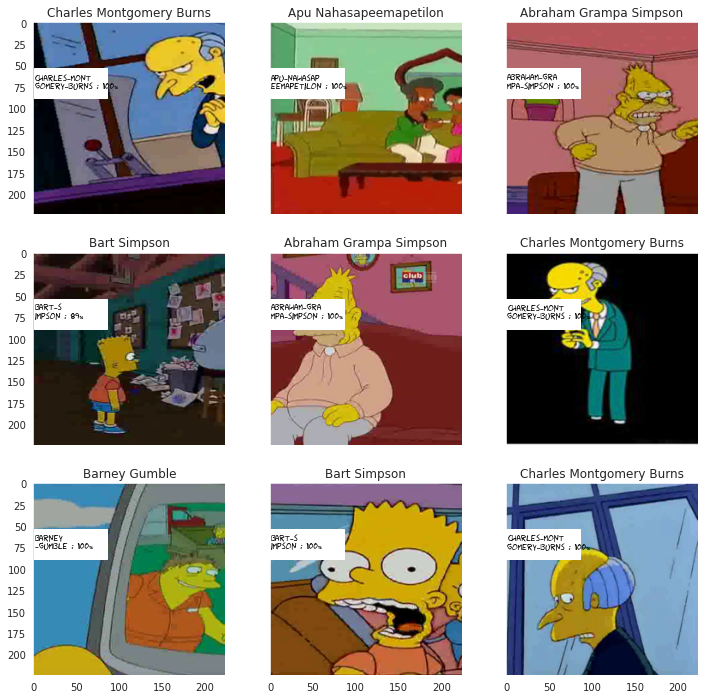

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(custom_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Посмотрим как наша нейронная сеть работает на тестовой выборке. Стоит отметить - сеть сильно переобучается

<font size="2">Let's see how our neural network works on a test sample. It is worth noting - the network is heavily retraining </font>






In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(custom_cnn, test_loader)
label_encoder = pickle.load(open("/content/label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
submission = pd.read_csv("/content/sample_submission.csv")
submission = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submission.head()

Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon

In [ ]:
submission.to_csv('Arty_base.csv', index=False)

In [ ]:
torch.cuda.empty_cache()

### Kaggle score

In [ ]:
kaggle = 0.95536
print(f'Kaggle score for Arty_base is {kaggle} f1_score')

Kaggle score for Arty_base is 0.95536 f1_score


## FineTuning для EfficientNet и Аугментация / FineTuning of EfficientNet and Augmentation

<a id='best'></a>

Попробуем для начала взять `предобученную модель` из зоопарка - и переобучить все слои. Используем `FineTuning` метод, добавим аугментации (используем новый класс [SimpsonsDatasetAug](#simp)). Данные - мультсериал. Думаю, что стоит разморозить все слои, но оставить веса для инициализации


<font size="2">Let's try to start with a `pre-trained model` from the zoo - we won't change anything. We do it as it is. We use the `Feature Extractor` method. It is pointless to use `FineTuning` in this situation and [SimpsonsDatasetAug](#simp). Data is cartoon. I think it's worth unfreezing all layers, but leaving the weights to initialize </font>






In [ ]:
val_dataset = SimpsonsDatasetAug(val_files, mode='val')
train_dataset = SimpsonsDatasetAug(train_files, mode='train')

In [ ]:
Eff_mod = EfficientNet.from_pretrained('efficientnet-b2')

Loaded pretrained weights for efficientnet-b2


In [ ]:
for param in Eff_mod.parameters():
    param.requires_grad = True

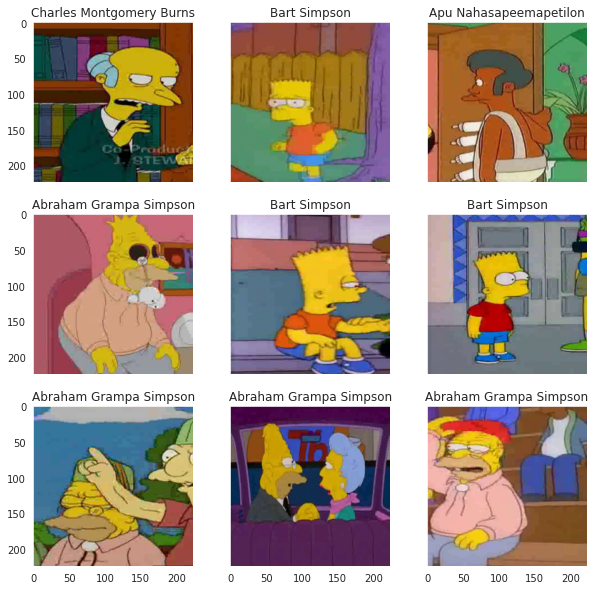

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(10, 10), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [ ]:
%%capture
# для проверки input последнего слоя/to check the inputs of the last layer
Eff_mod

Заменим этот выход на требуемый в нашей задаче - `42 класса`. Использовать будем AdamW и количесто эпох установим на 20 с ранней остановкой, шедулер на 3 шага, batch_size на 32

<font size="2">Let's replace this output with the one required in our task - `42 classes`. We will use `AdamW` and set the number of epochs to `20` with shceduler for 3 steps and batch of 32 samples </font>






In [ ]:
n_classes = len(np.unique(train_val_labels))
num_features = Eff_mod._fc.in_features
Eff_mod._fc = nn.Linear(num_features, n_classes)

Eff_mod.cuda()
optimizer = optim.AdamW(Eff_mod.parameters(), lr=1e-3, weight_decay=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 0.5928633074769188

Epoch 001 train_loss: 0.5929     val_loss 0.2979 train_acc 0.8551 val_acc 0.9207
loss 0.4437695448945621

Epoch 002 train_loss: 0.4438     val_loss 0.2354 train_acc 0.8877 val_acc 0.9389
loss 0.21799278190390678

Epoch 003 train_loss: 0.2180     val_loss 0.2320 train_acc 0.9433 val_acc 0.9459
loss 0.07727744495690142

Epoch 004 train_loss: 0.0773     val_loss 0.1102 train_acc 0.9814 val_acc 0.9757
loss 0.04190197746685175

Epoch 005 train_loss: 0.0419     val_loss 0.1040 train_acc 0.9910 val_acc 0.9788
loss 0.03367788765173214

Epoch 006 train_loss: 0.0337     val_loss 0.1043 train_acc 0.9918 val_acc 0.9784
loss 0.023944281236032375

Epoch 007 train_loss: 0.0239     val_loss 0.1004 train_acc 0.9942 val_acc 0.9803
loss 0.020878497481167744

Epoch 008 train_loss: 0.0209     val_loss 0.1006 train_acc 0.9954 val_acc 0.9803
loss 0.018992441383015625

Epoch 009 train_loss: 0.0190     val_loss 0.1010 train_acc 0.9953 val_acc 0.9803
loss 0.017537111382881877

Epoch 010

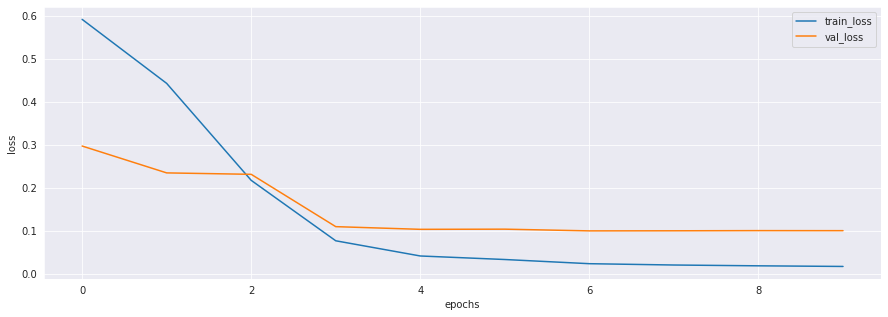

In [ ]:
history = train(train_dataset, val_dataset, 
                model=Eff_mod, epochs=20, 
                batch_size=32, optimizer=optimizer,
                scheduler=exp_lr_scheduler,
                patience=2
                )

loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Для сравнения, ниже представлены результаты для Feature extractions   
<font size="2">Only the results of the  Feature extractions are presented below. </font>
```
Epoch 047 train_loss: 0.7733     val_loss 0.8929 train_acc 0.8064 val_acc 0.7721
loss 0.7719837215092693

Epoch 048 train_loss: 0.7720     val_loss 0.8929 train_acc 0.8071 val_acc 0.7721
loss 0.7687502685789318

Epoch 049 train_loss: 0.7688     val_loss 0.8929 train_acc 0.8085 val_acc 0.7721
loss 0.7664765505374894

Epoch 050 train_loss: 0.7665     val_loss 0.8929 train_acc 0.8074 val_acc 0.7721
```

Отлично. Сработала ранняя остановка. 

<font size="2"> Fine. An earlystopping was triggered. </font>






In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]

probs_im = predict_one_sample(Eff_mod, ex_img.unsqueeze(0))
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(Eff_mod, imgs)
label_encoder = pickle.load(open("/content/label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [label_encoder.classes_[val_dataset[id][1]] for id in idxs]
preds_class = [label_encoder.classes_[y_hat] for y_hat in y_pred]
label_encoder.transform(preds_class)
f1_score(actual_labels, preds_class, average='weighted')

1.0

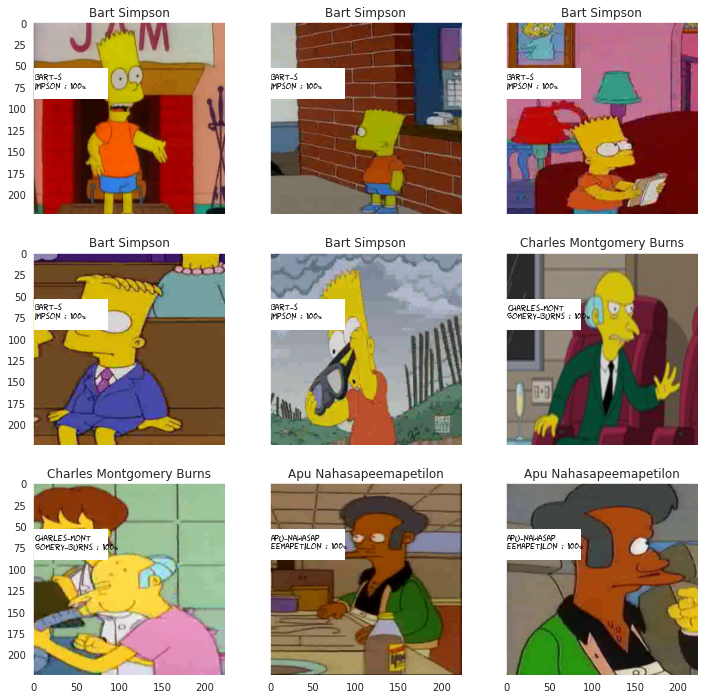

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(Eff_mod, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Посмотрим как наша сеть работает на тестовой выборке.

<font size="2">Let's see how our neural network works on a test sample.  </font>






In [ ]:
test_dataset = SimpsonsDatasetAug(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=32)

In [ ]:
probs = predict(Eff_mod, test_loader)

In [ ]:
label_encoder = pickle.load(open("/content/label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
submission = pd.read_csv("/content/sample_submission.csv")
submission = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submission.head()

Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon

In [ ]:
submission.to_csv('efficientnet_fine.csv', index=False)

In [ ]:
files.download('efficientnet_fine.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# сохраненная модель
%%capture
!gdown --id 12zBD1djfSPFCcATlJi3-nw7GyCmuJTJp

In [ ]:
torch.cuda.empty_cache()

### Kaggle score

In [ ]:
kaggle = 0.98989
print(f'Kaggle score for efficientnet_fine is {kaggle} f1_score')

Kaggle score for efficientnet_fine is 0.98989 f1_score


## FineTuning для EfficientNet и Аугментация с ансамбль с жестким голосованием / FineTuning of EfficientNet and Augmentation with hard-voting ensembling

<a id='best2'></a>

Попробуем для начала взять `предобученную модель` из зоопарка - и переобучить все слои. Используем `FineTuning` метод, добавим аугментации (используем новый класс [SimpsonsDatasetAug](#simp)) и ансамблирование. Данные - мультсериал. Думаю, что стоит разморозить все слои, но оставить веса для инициализации


<font size="2">Let's try to start with a `pre-trained model` from the zoo - we won't change anything. We do it as it is. We use the `Feature Extractor` method. It is pointless to use `FineTuning` in this situation and [SimpsonsDatasetAug](#simp) and ensembling. Data is cartoon. I think it's worth unfreezing all layers, but leaving the weights to initialize </font>






In [ ]:
TRAIN_DIR = Path('/content/train')
TEST_DIR = Path('/content/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
# заглушка, если перезапускать. Нам необходимо создать энкодер


train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)
data_for_label = SimpsonsDatasetAug(train_files, mode="train")

Подберем параметр `count` по медианному значению количества классов

In [ ]:
np.median([count for x, count in Counter(train_val_labels).items()])

154.5

In [ ]:
balanced, y_balanced = balancing_data_CV(train_val_files, 155)

test_dataset = SimpsonsDatasetAug(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=32)
# сюда будем собирать предсказания каждой сети
cross_accum = pd.DataFrame(columns=['Id'])
# энкодер понадобится для стратифицированного разбиения выборки по n_folds
label_encoder = pickle.load(open("/content/label_encoder.pkl", 'rb'))

По сути, мы сейчас проведем 5 раз обучения нейронной сети. дальше возьмем наиболее часто встречающееся предсказание как верное (жесткое голосование). Добавим раннее прекращение, на случай переобучения, на 2 эпохи. В таком случае - будем контролировать ухудшение качества предсказний для каждой итерации нашего цикла. Попробуем поднять количество редких классов и на этом сете учиться - изменили функцию `balancing_data` на `balancing_data_CV` - мы будем использовать `train_test_split` и делать стратификацию по `y` - поэтому подготовим и повысим образцы на всей выборке. 

<font size="2">Basically, we will now train the neural network 5 times. further we will take the most common prediction as correct (hard voting). Let's add an early stopping, in case of retraining, for 2 epochs. In this case, we will control the deterioration in the quality of predictions for each iteration of our cycle. Let's try to increase the number of rare classes and learn on this set - we changed the `balancing_data` function to` balancing_data_CV`</font>






In [ ]:
train_val_files[:5]

[PosixPath('/content/train/simpsons_dataset/abraham_grampa_simpson/pic_0000.jpg'),
 PosixPath('/content/train/simpsons_dataset/abraham_grampa_simpson/pic_0001.jpg'),
 PosixPath('/content/train/simpsons_dataset/abraham_grampa_simpson/pic_0002.jpg'),
 PosixPath('/content/train/simpsons_dataset/abraham_grampa_simpson/pic_0003.jpg'),
 PosixPath('/content/train/simpsons_dataset/abraham_grampa_simpson/pic_0004.jpg')]

In [ ]:
train_val_labels[:5]

['abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson']

In [ ]:
balanced[:5]

[PosixPath('/content/train/simpsons_dataset/abraham_grampa_simpson/pic_0000.jpg'),
 PosixPath('/content/train/simpsons_dataset/abraham_grampa_simpson/pic_0001.jpg'),
 PosixPath('/content/train/simpsons_dataset/abraham_grampa_simpson/pic_0002.jpg'),
 PosixPath('/content/train/simpsons_dataset/abraham_grampa_simpson/pic_0003.jpg'),
 PosixPath('/content/train/simpsons_dataset/abraham_grampa_simpson/pic_0004.jpg')]

In [ ]:
y_balanced[:5]

['abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson']

In [ ]:
n_folds = 5

n_classes = len(np.unique(y_balanced))
e_net = EfficientNet.from_pretrained('efficientnet-b2')
num_features = e_net._fc.in_features
e_net._fc = nn.Linear(num_features, n_classes)


# делим выборки / divide the samples
for fold in range(n_folds):

    torch.cuda.empty_cache()
    train_files, val_files = train_test_split(balanced, test_size=0.25, \
                                          stratify=y_balanced, random_state=42+fold)
# создаем сеты / create data
    
    val_dataset = SimpsonsDatasetAug(val_files, mode='val')
    train_dataset = SimpsonsDatasetAug(train_files, mode='train')

# грузим новую модель каждый fold. Веса обучаем
# load a new model each fold. We train weights

    model = copy.deepcopy(e_net)
    model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


# важно поставить раннюю остановку, иначе будем переобучаться. Шаг небольшой 
# it is important to use early stopping, otherwise we will retrain. Small step

    history = train(train_dataset, val_dataset, 
                model=model, epochs=10, 
                batch_size=32, optimizer=optimizer,
                scheduler=exp_lr_scheduler,
                patience=2
                )
    
    probs = predict(model, test_loader)
    preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))

    cross_accum[f'preds_{fold + 1}'] = preds

# собираем сет из предсказаний и берем моду - самое частое значение образца
# collect a set of predictions and take a mode - the most common value of the sample

test_filenames = [path.name for path in test_dataset.files]
cross_accum['Id'] = test_filenames
cross_accum['Expected'] = cross_accum.mode(axis=1)[0]
preds_ensemble = cross_accum['Expected']

Loaded pretrained weights for efficientnet-b2


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.5903719709729053

Epoch 001 train_loss: 0.5904     val_loss 0.2250 train_acc 0.8546 val_acc 0.9427
loss 0.3968207581470759

Epoch 002 train_loss: 0.3968     val_loss 0.2284 train_acc 0.8968 val_acc 0.9415
loss 0.20058227875516854

Epoch 003 train_loss: 0.2006     val_loss 0.2037 train_acc 0.9481 val_acc 0.9481
loss 0.06918495088495956

Epoch 004 train_loss: 0.0692     val_loss 0.0902 train_acc 0.9821 val_acc 0.9810
loss 0.035893625148393414

Epoch 005 train_loss: 0.0359     val_loss 0.0810 train_acc 0.9911 val_acc 0.9850
loss 0.026314829453540255

Epoch 006 train_loss: 0.0263     val_loss 0.0806 train_acc 0.9937 val_acc 0.9840
loss 0.017590045456553884

Epoch 007 train_loss: 0.0176     val_loss 0.0771 train_acc 0.9962 val_acc 0.9842
loss 0.01616022837780933

Epoch 008 train_loss: 0.0162     val_loss 0.0753 train_acc 0.9961 val_acc 0.9850
loss 0.01463944904425922

Epoch 009 train_loss: 0.0146     val_loss 0.0750 train_acc 0.9966 val_acc 0.9850
loss 0.013451354759966271

Epoch 010

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.59726402827393

Epoch 001 train_loss: 0.5973     val_loss 0.1997 train_acc 0.8517 val_acc 0.9483
loss 0.5267960212650177

Epoch 002 train_loss: 0.5268     val_loss 0.2487 train_acc 0.8691 val_acc 0.9351
loss 0.1924373634494102

Epoch 003 train_loss: 0.1924     val_loss 0.1969 train_acc 0.9489 val_acc 0.9497
loss 0.05854399340358911

Epoch 004 train_loss: 0.0585     val_loss 0.0861 train_acc 0.9852 val_acc 0.9831
loss 0.036308603065800686

Epoch 005 train_loss: 0.0363     val_loss 0.0804 train_acc 0.9915 val_acc 0.9836
loss 0.025008331108909296

Epoch 006 train_loss: 0.0250     val_loss 0.0811 train_acc 0.9940 val_acc 0.9852
loss 0.01714056306921928

Epoch 007 train_loss: 0.0171     val_loss 0.0755 train_acc 0.9960 val_acc 0.9866
loss 0.0147289147407438

Epoch 008 train_loss: 0.0147     val_loss 0.0755 train_acc 0.9963 val_acc 0.9875
loss 0.012499564705294836

Epoch 009 train_loss: 0.0125     val_loss 0.0757 train_acc 0.9973 val_acc 0.9868
loss 0.013339985325141652

Epoch 010 tra

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.5982053808635398

Epoch 001 train_loss: 0.5982     val_loss 0.3171 train_acc 0.8493 val_acc 0.9125
loss 50.574461590207804

Epoch 002 train_loss: 50.5745     val_loss 3.5397 train_acc 0.1261 val_acc 0.0976
loss 3.4779079373135398

Epoch 003 train_loss: 3.4779     val_loss 3.4288 train_acc 0.0977 val_acc 0.0976
loss 3.423955159115949

Epoch 004 train_loss: 3.4240     val_loss 3.4210 train_acc 0.0977 val_acc 0.0976


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.5851995133789334

Epoch 001 train_loss: 0.5852     val_loss 0.2690 train_acc 0.8531 val_acc 0.9311
loss 0.39493539325105426

Epoch 002 train_loss: 0.3949     val_loss 0.2125 train_acc 0.8974 val_acc 0.9516
loss 0.1899744219337169

Epoch 003 train_loss: 0.1900     val_loss 0.1737 train_acc 0.9488 val_acc 0.9568
loss 0.06013699508045089

Epoch 004 train_loss: 0.0601     val_loss 0.0860 train_acc 0.9853 val_acc 0.9836
loss 0.0335703868239352

Epoch 005 train_loss: 0.0336     val_loss 0.0820 train_acc 0.9919 val_acc 0.9835
loss 0.024179934010524245

Epoch 006 train_loss: 0.0242     val_loss 0.0842 train_acc 0.9944 val_acc 0.9850
loss 0.015309830726042032

Epoch 007 train_loss: 0.0153     val_loss 0.0792 train_acc 0.9966 val_acc 0.9856
loss 0.013658630033463978

Epoch 008 train_loss: 0.0137     val_loss 0.0801 train_acc 0.9970 val_acc 0.9859
loss 0.012269486560313262

Epoch 009 train_loss: 0.0123     val_loss 0.0798 train_acc 0.9973 val_acc 0.9856
loss 0.010255365042550348

Epoch 010

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.5922842022368244

Epoch 001 train_loss: 0.5923     val_loss 0.2829 train_acc 0.8510 val_acc 0.9286
loss 117.09840763175359

Epoch 002 train_loss: 117.0984     val_loss 3.3330 train_acc 0.0958 val_acc 0.0978
loss 3.337076611468515

Epoch 003 train_loss: 3.3371     val_loss 3.3296 train_acc 0.0969 val_acc 0.0978
loss 3.3232694843941517

Epoch 004 train_loss: 3.3233     val_loss 3.3234 train_acc 0.0977 val_acc 0.0978


___
На некоторых моделях (`3-я и 5-я модель`) понадобилась ранняя остановка. Резко вырос `loss` - модель будет загружаться на момент лучшей эпохи  

<font size="2">On some models (`3rd model and 5th) an early stopping was required. `Loss` has grown sharply - the model will be loaded at the time of the best epoch</font>



In [ ]:
cross_accum.sample(5)

Id  ...                Expected
367  img429.jpg  ...           kent_brockman
383  img443.jpg  ...  apu_nahasapeemapetilon
775  img797.jpg  ...             moe_szyslak
369  img430.jpg  ...           homer_simpson
207  img285.jpg  ...            ned_flanders

[5 rows x 7 columns]

Проверим скор  
<font size="2">Check the speed</font>






In [ ]:
submission = pd.read_csv("/content/sample_submission.csv")
submission = pd.DataFrame({'Id': test_filenames, 'Expected': preds_ensemble})
submission.head()

Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon

In [ ]:
submission.to_csv('EffNet_CV.csv', index=False)

In [ ]:
files.download('EffNet_CV.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
torch.cuda.empty_cache()

### Kaggle score

In [ ]:
kaggle = 0.99663
print(f'Kaggle score for EffNet_CV is {kaggle} f1_score')

Kaggle score for EffNet_CV is 0.99663 f1_score


<<img src="https://i.ibb.co/hDmH2Lj/simpsons-main.jpg" alt="simpsons-main" border="0">

## Вывод / Summary

<a id='summary'></a>

Основным заданием было обучить классификатор на основе сверточных сетей, чтобы научиться отличать всех жителей Спрингфилда. Основная метрика - `F1-score` - необходимо получить свыше `0.97`. Лучший результат достигли на модели на базе `FineTuning для EfficientNet и Аугментация / FineTuning of EfficientNet and Augmentation`  - [kaggle_score](#best) - `0.99256` и `FineTuning для EfficientNet и Аугментация с ансамбль с жестким голосованием / FineTuning of EfficientNet and Augmentation with hard-voting ensembling` -  [kaggle_score](#best2) - `0.99787`. Также, неплохо себя показали обе кастомные нейронные сети  `SimpsonsConvNet` и `ArtyNet` - у всех скор выше `0.96`
___




<img src="https://i.ibb.co/WBw0N72/maxresdefault.jpg" alt="maxresdefault" border="0"></a>